# Notebook for training AutoEncoder

## Imports

In [1]:
import torch
import numpy as np
# This import registers the 3D projection, but is otherwise unused.
# get rid of uninteresting warning
from dataloader import UTKFaceDataset
from torchvision.utils import make_grid

from ae import AutoEncoderNet
from torch.utils.tensorboard import SummaryWriter



## Import dataset

In [2]:
BATCH_SIZE = 64
EPOCH = 10000

train_dataset = UTKFaceDataset(gray_scale=False)
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    BATCH_SIZE, 
    shuffle=True, 
    num_workers=4, 
    pin_memory=True)

In [3]:
test_dataset = UTKFaceDataset(data_type="test",gray_scale=False)
test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    BATCH_SIZE, 
    shuffle=True, 
    num_workers=4, 
    pin_memory=True)

## Early stopping

In [4]:
# from https://gist.github.com/stefanonardo/693d96ceb2f531fa05db530f3e21517d

class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.bestModel = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics, curmodel):
        if self.best is None:
            self.best = metrics
            self.bestModel = curmodel
            return False

        if torch.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
            self.bestModel = curmodel
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)
                

                
# play around with patience
# The early stopping module takes in the following parameters
# mode='min' / 'max' - whether smaller or lager is better
# min_delta=0 - a delta that can be used to be more lenient when evaulating "bad" epochs
# patience=10 - how many "bad" epochs that are allowed(epoches with worse score than the current best)
# percentage=False / True - whether the criterion is in percentage or not
earlyStopping = EarlyStopping(patience=5)

### 3)  Training

In [5]:
classes = [0,1]
device = "cuda"

learning_rate = 0.001
# L2 Regularization is added to the optimizer as weight decay, use a number between 0 and 1
# If more regularization is desired then you can add dropout to the network 
weight_decay = 0.0
    
aenet = AutoEncoderNet(n_channels=3, dim_last_layer=(64, 21, 21), latent_features=256)     # define the network
aenet = aenet.to(device)

print(aenet)  # net architecture
optimizer = torch.optim.Adam(aenet.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_func = torch.nn.MSELoss()  # MSE loss function


AutoEncoderNet(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Flatten(start_dim=1, end_dim=-1)
    (12): Linear(in_features=28224, out_features=512, bias=True)
    (13): ReLU()
    (14): Linear(in_features=512, out_features=256, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=28224, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(64, 21, 21))
    (3): ConvTranspose2d(64, 64, kerne

Epoch 1/10000
Epoch 2/10000
Epoch 3/10000
Epoch 4/10000
Epoch 5/10000
Epoch 6/10000
Epoch 7/10000
Epoch 8/10000
Epoch 9/10000
Epoch 10/10000
Epoch 11/10000
Epoch 12/10000
Epoch 13/10000
Epoch 14/10000
Epoch 15/10000
Epoch 16/10000
Epoch 17/10000
Epoch 18/10000
Epoch 19/10000
Epoch 20/10000
Epoch 21/10000
Epoch 22/10000
Stopping early
Finished Training


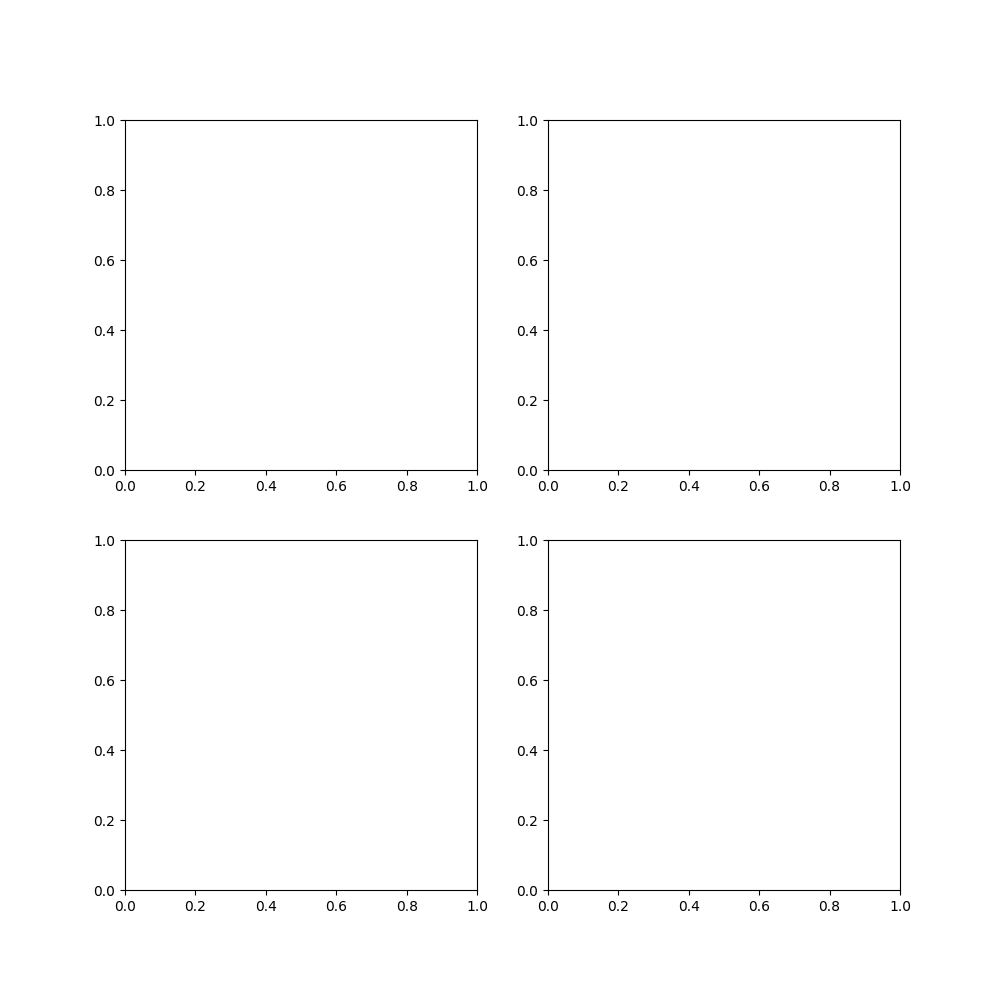

In [22]:
writer = SummaryWriter()

# train the neural network
average_test_loss=[]
average_train_loss=[]
for epoch in range(EPOCH):  # loop over the dataset multiple times
    print(f"Epoch {epoch+1}/{EPOCH}")
    train_loss_graph = 0
    aenet.train()
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        xtrain, ytrain = data
        xtrain = xtrain.to(device)
        # forward + backward + optimize
        latent_space, x_reconstruction = aenet(xtrain)

        loss = loss_func(x_reconstruction, xtrain)
        train_loss_graph += loss.item() * xtrain.shape[0] #Multiply with the current batchsize to get pr. sample loss
        
        # zero the parameter gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # testing
    test_loss_graph  = 0
    with torch.no_grad():
        aenet.eval()
        for data in test_loader:
            xtest, ytest = data
            xtest = xtest.to(device)
            latent_space, x_reconstruction = aenet(xtest)
            loss = loss_func(x_reconstruction, xtest)
            test_loss_graph += loss.item() * xtest.shape[0] #Multiply with the current batchsize to get pr. sample loss

    writer.add_scalar('Loss/train',  train_loss_graph/len(train_dataset),epoch)
    writer.add_scalar('Loss/test', test_loss_graph/len(test_dataset),epoch)

    # plotting code from dtu deep learning course
    if epoch % 10 == 0:

        grid1 = np.asarray(make_grid(xtest.cpu(),nrow=4,ncol=4))
        grid2 = np.asarray(make_grid(x_reconstruction.cpu(),nrow=4,ncol=4))
        writer.add_image('True', grid1, epoch)
        writer.add_image('Reconstructed', grid2, epoch)

    if earlyStopping.step(torch.tensor(test_loss_graph/len(test_dataset)),aenet):
        print("Stopping early") 
        aenet = earlyStopping.bestModel
        break

print('Finished Training')

import time
current_time = time.time()
torch.save(aenet.state_dict(), f"models/{current_time}.pt")